### Demo for deskewing and using pyclesperanto_prototype and its affinetranform3d class

This notebook is for educational purposes only. 
It demonstrates how to set use pyclesperanto_prototype for deskewing using just affine transforms

However, this method leads to artefacts if the data is anisotropic in Z. More information [here](https://github.com/clEsperanto/pyclesperanto_prototype/issues/196).

We recommend using the pyclesperanto `deskew_y` or `deskew_x` functions instead. Refer to this [notebook](https://github.com/clEsperanto/pyclesperanto_prototype/blob/master/demo/transforms/deskew.ipynb).

In [22]:
from aicsimageio import AICSImage
import pyclesperanto_prototype as cle
import numpy as np
import math,sys

#print versions of python and packages
print(f"Numpy version: {np.__version__}")
print(f"pyclesperanto_prototype version: {cle.__version__}")
print(f"Python version: {'.'.join(map(str, list(sys.version_info)[:3]))}")

#decimal places when printing floats is set to 3
np.set_printoptions(3)

Numpy version: 1.26.4
pyclesperanto_prototype version: 0.24.5
Python version: 3.10.0


In [2]:
#download sample data from https://zenodo.org/records/14903188
img_path = "./sample_data/RBC_tiny.czi"
import os 
#make dir if not exists
if not os.path.exists("./sample_data"):
    os.makedirs("./sample_data")
import urllib.request
url = "https://zenodo.org/records/14903188/files/RBC_tiny.czi?download=1"
if not os.path.exists(img_path):
    print("Downloading file")
    urllib.request.urlretrieve(url, img_path)
    print(f"Downloaded at : {img_path}")
else:
    print(f"File already exists at : {img_path}")

File already exists at : ./sample_data/RBC_tiny.czi


In [3]:
rbc_aics = AICSImage(img_path)

voxel_size_x = rbc_aics.physical_pixel_sizes.X
voxel_size_y = rbc_aics.physical_pixel_sizes.Y
voxel_size_z = rbc_aics.physical_pixel_sizes.Z

rbc = rbc_aics.dask_data[0,0,...]

print("Shape",rbc.shape)



Shape (834, 118, 209)


Max X projection


c:\Users\Pradeep\.conda\envs\napari-lattice\lib\site-packages\pyclesperanto_prototype\_tier9\_imshow.py:35: UserWarning: cle.imshow is deprecated, use stackview.imshow instead.
  warnings.warn("cle.imshow is deprecated, use stackview.imshow instead.")


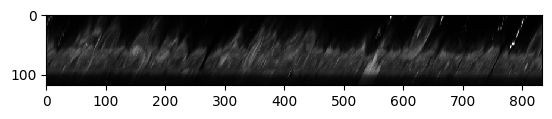

In [4]:
print("Max X projection")
cle.imshow(cle.maximum_x_projection(rbc))

Deskewing is implemented as a series of transformations in pyclesperanto. 

cle.AffineTransform3D is a class to setup and work with affine transform matrices

In [5]:
#initialise a transform
shear_transform =cle.AffineTransform3D()
#To access the matrix you call the ._matrix method
shear_transform._matrix

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

The deskew_y function calls the function here:
https://github.com/clEsperanto/pyclesperanto_prototype/blob/master/pyclesperanto_prototype/_tier8/_deskew_y.py

which in turn uses the transform defined here:

https://github.com/clEsperanto/pyclesperanto_prototype/blob/50a1f3ae6387963019c6997c69f239fb81adc4dc/pyclesperanto_prototype/_tier8/_AffineTransform3D.py#L301

* Shear in XZ plane along Y axis around 90-deskew_angle
* Coverslip rotation 
* Scale the image
* Rotate it 90 degrees around X so that the Z plane is prox to distal

Biggest point to keep in mind is the transforms in Clesperanto are all for images in the XYZ order. You pass the images as a ZYX array to clesperanto. AS it usees OpenCL, images are processed in the XYZ format, hence affine transforms are in the XYZ format. 

However, gputools and other libraries in python use affine transforms in ZYX format. This is the biggest difference to keep in mind.

In [6]:
print("Before shearing")
print(shear_transform._matrix)

Before shearing
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [7]:
#To apply a transform, you call the associated methods in the AffineTransform3D class
#Shear in X plane:
deskewing_angle = 30
#Current shearing doesn't take into account pixel sizes; change when fixed in clesperanto
#shear_transform.shear_in_x_plane(angle_y_in_degrees = 90 - deskewing_angle)
#Shearing with pixel size taken into account; Thanks Lachie!
shear_factor = math.sin((90 - deskewing_angle) * math.pi / 180.0) * (voxel_size_z/voxel_size_y)
shear_transform._matrix[1, 2] = shear_factor

print("After shearing in X plane")
print(shear_transform._matrix)

print("Note that the matrix is different from above as we applied shearing")

After shearing in X plane
[[1.    0.    0.    0.   ]
 [0.    1.    1.792 0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    0.    1.   ]]
Note that the matrix is different from above as we applied shearing


Once you've defined a transformation, to apply it, you use:
`affine_transform` method

(834, 1612, 209)
After shearing


c:\Users\Pradeep\.conda\envs\napari-lattice\lib\site-packages\pyclesperanto_prototype\_tier9\_imshow.py:35: UserWarning: cle.imshow is deprecated, use stackview.imshow instead.
  warnings.warn("cle.imshow is deprecated, use stackview.imshow instead.")


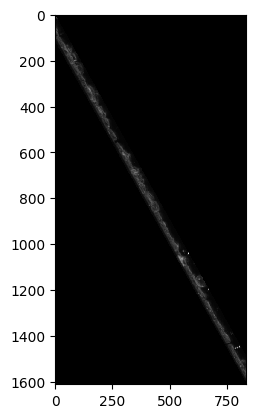

In [8]:
#Auto size is the speial method that determines if the image is out of bounds and if so, moves it back in bounds
shear_transformed = cle.affine_transform(source= rbc,transform = shear_transform,auto_size=True)
print(shear_transformed.shape)
print("After shearing")
cle.imshow(cle.maximum_x_projection(shear_transformed))

(84, 1813, 209)
After shearing and rotating


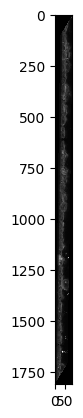

In [9]:
shear_transform.rotate(angle_in_degrees = 0 - deskewing_angle, axis=0)
#Auto size is the special method that determines if the image is out of bounds and if so, moves it back in bounds
shear_transformed = cle.affine_transform(source= rbc,transform = shear_transform,auto_size=True)
print(shear_transformed.shape)
print("After shearing and rotating")
cle.imshow(cle.maximum_x_projection(shear_transformed))


Implementation for deskewing below. 

In [10]:
#Defining Deskewing
deskewing_angle = 30
scale_factor = 1 #Scale factor is used in clesperanto if we want to scale the images in case they don't fit in memory

#initialise a transform
deskew_transform =cle.AffineTransform3D()
#Shear
shear_factor = math.sin((90 - deskewing_angle) * math.pi / 180.0) * (voxel_size_z/voxel_size_y)
deskew_transform._matrix[1, 2] = shear_factor
#Scale
new_dz = math.sin(deskewing_angle * math.pi / 180.0) * voxel_size_z
scale_factor_z = (new_dz / voxel_size_y) * scale_factor
deskew_transform.scale(scale_x=scale_factor, scale_y=scale_factor, scale_z=scale_factor_z)
#Rotate deskewing angle
deskew_transform.rotate(angle_in_degrees = 0 - deskewing_angle, axis=0)

print("Affine transformation for deskewing")
print(deskew_transform._matrix)


Affine transformation for deskewing
[[ 1.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  8.660e-01  2.069e+00  0.000e+00]
 [ 0.000e+00 -5.000e-01  6.015e-17  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]


Once you've defined a transformation, to apply it, you use:
`affine_transform` method

In [11]:
#Auto size is the special method that determines if the image is out of bounds and if so, moves it back in
deskewed = cle.affine_transform(source= rbc,transform = deskew_transform,auto_size=True)
print(deskewed.shape)


(59, 1828, 209)


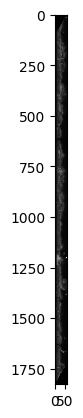

In [12]:
cle.imshow(cle.maximum_x_projection(deskewed))

In [13]:
import napari 
viewer = napari.Viewer()
viewer.add_image(rbc)
viewer.add_image(deskewed)

<Image layer 'deskewed' at 0x214a3943550>

3D view of raw and deskewed data

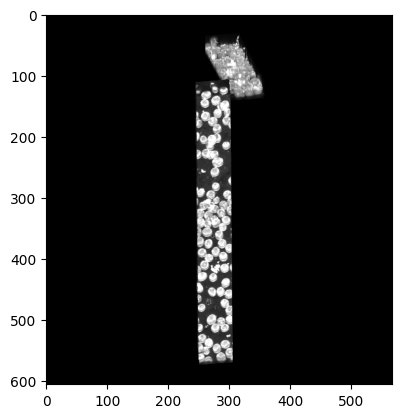

In [ ]:
#screenshot
a = viewer.screenshot()
import matplotlib.pyplot as plt

plt.imshow(a)
